In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torch.utils.data as data
from torch.utils.data import DataLoader, TensorDataset
import pickle
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

#Cargar datos y exploración

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/td_ztf_stamp_17_06_20.pkl', 'rb') as file:
    data = pickle.load(file)

print(type(data))
print(data.keys())

<class 'dict'>
dict_keys(['Train', 'Validation', 'Test'])


In [ ]:
train_data = data["Train"]

# Si train_data es un DataFrame:
if isinstance(train_data, pd.DataFrame):
    print(train_data.head())
    print(train_data.info())
else:
    print(type(train_data))

<class 'dict'>


In [ ]:
print(train_data.keys())

#Pre procesamiento de datos

In [ ]:
# Cargar los datos
train_data = data["Train"]
val_data = data["Validation"]
test_data = data["Test"]

# Convertir los datos de entrenamiento a un tensor de PyTorch.
train_images = torch.from_numpy(train_data["images"])
train_labels = torch.from_numpy(train_data["labels"])
train_features = torch.from_numpy(train_data["features"].astype(np.float32))

# Convertir los datos de validación a un tensor de PyTorch.
val_images = torch.from_numpy(val_data["images"])
val_labels = torch.from_numpy(val_data["labels"])
val_features = torch.from_numpy(val_data["features"].astype(np.float32))

# Convertir los datos de prueba a un tensor de PyTorch.
test_images = torch.from_numpy(test_data["images"])
test_labels = torch.from_numpy(test_data["labels"])
test_features = torch.from_numpy(test_data["features"].astype(np.float32))

In [ ]:
# Cambiar la forma de los datos de entrada
train_images = train_images.permute(0, 3, 1, 2)
val_images = val_images.permute(0, 3, 1, 2)
test_images = test_images.permute(0, 3, 1, 2)

In [ ]:
# Aplicar recorte al centro
def center_crop_images(images):
    cropped_images = TF.center_crop(images, (21, 21))
    return cropped_images

In [ ]:
# Aplicar el preprocesamiento a los conjuntos de entrenamiento, validación y prueba
train_images = center_crop_images(train_images)
val_images = center_crop_images(val_images)
test_images = center_crop_images(test_images)

# Crear dataloader de entrenamiento
train_dataset = TensorDataset(train_images, train_labels, train_features)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Crear dataloader de validación
val_dataset = TensorDataset(val_images, val_labels, val_features)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Crear dataloader de prueba
test_dataset = TensorDataset(test_images, test_labels, test_features)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Mejor Modelo

##Modelo Crop, sin ZPadd + Capas convolucionales adicionales + Metadatos

# Arquitectura con Concatenación de Metadata

| Capa | Tipo de Capa           | Entradas                  | Salidas                  | Kernel/Pool |
|------|------------------------|---------------------------|--------------------------|-------------|
| 1    | Rotaciones             | 3                         | 3                        | 3x3         |
| 2    | Conv1                  | 3                         | 32                       | 4x4         |
| 3    | Conv2                  | 32                        | 32                       | 3x3         |
| 4    | MaxPool1               | -                         | -                        | 2x2         |
| 5    | Conv3                  | 32                        | 64                       | 3x3         |
| 6    | Conv4                  | 64                        | 64                       | 3x3         |
| 7    | Conv5                  | 64                        | 64                       | 3x3         |
| 8    | MaxPool2               | -                         | -                        | 2x2         |
| 9    | Conv6                  | 64                        | 128                      | 3x3         |
| 10   | Conv7                  | 128                       | 128                      | 3x3         |
| 11   | Conv8                  | 128                       | 128                      | 3x3         |
| 12   | MaxPool3               | -                         | -                        | 2x2         |
| 13   | Cyclic Pooling         | -                         | 256                      | -           |
| 14   | Flatten                | -                         | 256                      | -           |
| 15   | Metadata FC            | 64                        | 64                       | -           |
| 16   | Concatenación          | 256 (Imagen) + 64 (Meta)  | 320                      | -           |
| 17   | Dense1                 | 320                       | 64                       | -           |
| 18   | Dense2                 | 64                        | 64                       | -           |
| 19   | Salida                 | 64                        | 5                        | -           |
| 20   | Dropout                | -                         | -                        | -           |


In [ ]:
#Rotaciones
def RotAugmentation(x_0):
    #print(x_0[1,1,:,:].shape)
    x_1 = x_0
    x_2 = x_0
    x_3 = x_0

    for i in range (x_0.shape[0]):
      for j in range (3):
        x_1[i,j,:,:] = torch.rot90(x_0[i,j,:,:], 1, [0,1])
        x_2[i,j,:,:] = torch.rot90(x_0[i,j,:,:], 2, [0,1])
        x_3[i,j,:,:] = torch.rot90(x_0[i,j,:,:], 3, [0,1])

    return [x_0,x_1,x_2,x_3]

In [ ]:
class CyclicPool(nn.Module):
    def __init__(self, in_channels):
        super(CyclicPool, self).__init__()
        self.in_channels = in_channels
        self.avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x_avg = self.avg_pool(x)
        x_max = self.max_pool(x)
        x = torch.cat([x_avg, x_max], dim=1)
        return x

In [ ]:
class SupernovaDetector(nn.Module):
    def __init__(self, num_metadata_features=320):
        super(SupernovaDetector, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=1, padding=2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv6 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv7 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv8 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.cyclic_pool = CyclicPool(128)
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(282, 64)
        self.dense2 = nn.Linear(64, 64)
        self.output_layer = nn.Linear(64, 5)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x, metadata):
        x_rotated_list = RotAugmentation(x)
        x_rotated = torch.cat(x_rotated_list, dim=0)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.conv6(x)
        x = F.relu(x)
        x = self.conv7(x)
        x = F.relu(x)
        x = self.conv8(x)
        x = F.relu(x)
        x = self.pool3(x)
        x = self.cyclic_pool(x)
        x = self.flatten(x)
        x = torch.cat((x, metadata), dim=1)
        x = self.dense1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.dense2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.output_layer(x)
        return x

#Entrenamiento

In [ ]:
# Número de épocas y tamaño de lote
num_epochs = 10
batch_size = 32

# Definir el modelo, optimizador y función de pérdida
model = SupernovaDetector()

# Seleccionar el optimizador y la función de pérdida
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Entrenar el modelo
for epoch in range(num_epochs):
    start_time = time.time()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels, features = data  # Obtener tanto imágenes como features

        # Poner a cero los gradientes
        optimizer.zero_grad()

        # Propagación hacia adelante
        outputs = model(inputs, features)  # Pasar tanto imágenes como features al modelo
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Calcular estadísticas
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Imprimir estadísticas
        if i % 100 == 99:  # Imprimir cada 100 lotes
            print(f'Época [{epoch + 1}, Lote {i + 1}], Pérdida: {running_loss / 100:.3f}, Precisión: {100 * correct / total:.2f}%')
            running_loss = 0.0

    end_time = time.time()
    print(f'Tiempo de época: {end_time - start_time:.2f} segundos')

print('Entrenamiento finalizado')


Época [1, Lote 100], Pérdida: 1.236, Precisión: 55.69%
Época [1, Lote 200], Pérdida: 0.674, Precisión: 67.19%
Época [1, Lote 300], Pérdida: 0.538, Precisión: 72.07%
Época [1, Lote 400], Pérdida: 0.510, Precisión: 74.82%
Época [1, Lote 500], Pérdida: 0.454, Precisión: 76.82%
Época [1, Lote 600], Pérdida: 0.459, Precisión: 78.08%
Época [1, Lote 700], Pérdida: 0.426, Precisión: 79.30%
Época [1, Lote 800], Pérdida: 0.440, Precisión: 80.07%
Época [1, Lote 900], Pérdida: 0.464, Precisión: 80.62%
Época [1, Lote 1000], Pérdida: 0.445, Precisión: 81.12%
Época [1, Lote 1100], Pérdida: 0.416, Precisión: 81.58%
Época [1, Lote 1200], Pérdida: 0.417, Precisión: 81.92%
Época [1, Lote 1300], Pérdida: 0.396, Precisión: 82.28%
Época [1, Lote 1400], Pérdida: 0.400, Precisión: 82.64%
Época [1, Lote 1500], Pérdida: 0.400, Precisión: 82.89%
Época [1, Lote 1600], Pérdida: 0.396, Precisión: 83.13%
Época [1, Lote 1700], Pérdida: 0.395, Precisión: 83.31%
Época [1, Lote 1800], Pérdida: 0.386, Precisión: 83.50%
É

In [ ]:
# Guardar el modelo
torch.save(model.state_dict(), 'bestmodel.pth')

# Para descargar el modelo
from google.colab import files
files.download('bestmodel.pth')
# 35min aprox.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import torch
model_path = '/content/drive/MyDrive/Colab Notebooks/bestmodel.pth'
model = SupernovaDetector()  # Instancia del modelo
model.load_state_dict(torch.load(model_path))
model.eval()  # Modelo en modo de evaluación

SupernovaDetector(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cyclic_pool): CyclicPool(
    (avg_pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (max_poo

#Evaluación del Modelo

Precisión en el conjunto de prueba: 0.95%


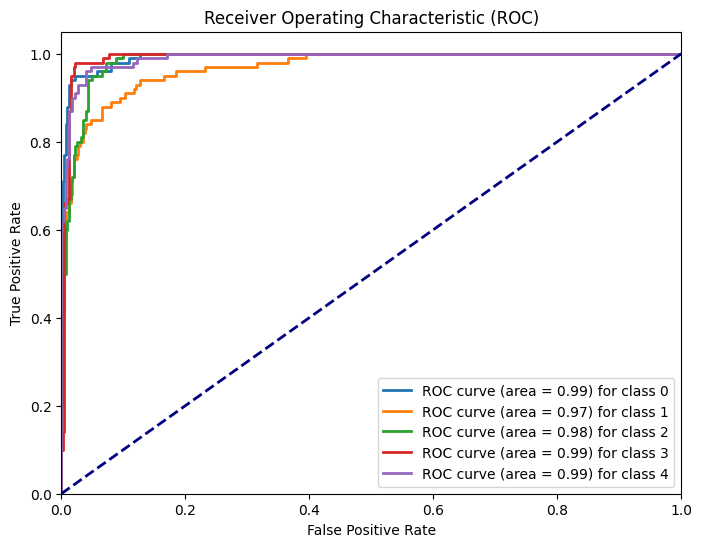

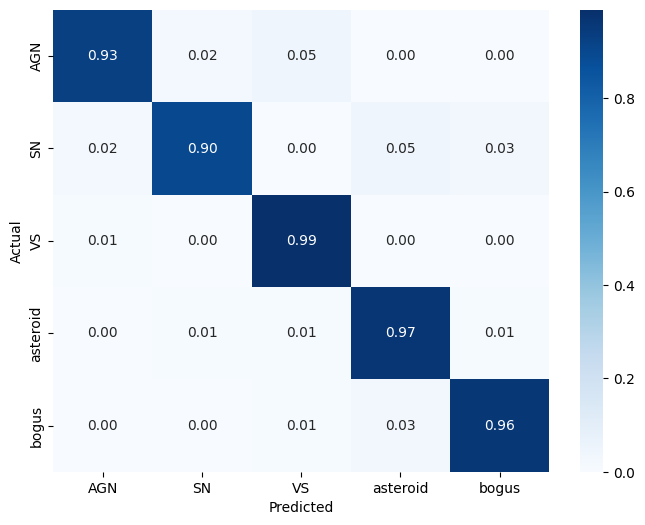

Accuracy: 0.95
Precision por clase: [0.96875    0.96774194 0.93396226 0.92380952 0.96      ]
Recall por clase: [0.93 0.9  0.99 0.97 0.96]
F1 Score por clase: [0.94897959 0.93264249 0.96116505 0.94634146 0.96      ]


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Función de evaluación de precisión
def evaluate_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels, features in data_loader:
            outputs = model(inputs, features)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Función de evaluación para ROC, matriz de confusión y métricas adicionales
def evaluate_model_metrics(model, data_loader):
    model.eval()
    all_labels = []
    all_scores = []

    with torch.no_grad():
        for inputs, labels, features in data_loader:
            outputs = model(inputs, features)
            all_labels.extend(labels.numpy())
            all_scores.extend(outputs.numpy())

    n_classes = len(np.unique(all_labels))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        true_labels = np.array(all_labels) == i
        scores = [score[i] for score in all_scores]
        fpr[i], tpr[i], _ = roc_curve(true_labels, scores)
        roc_auc[i] = roc_auc_score(true_labels, scores)

    # Coonfusion matrix
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_scores).argmax(axis=1)
    cm = confusion_matrix(all_labels, all_predictions)

    # Normalizar la matriz de confusión
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Métricas adicionales
    accuracy = accuracy_score(all_labels, all_predictions)
    precision_per_class = precision_score(all_labels, all_predictions, average=None)
    recall_per_class = recall_score(all_labels, all_predictions, average=None)
    f1_per_class = f1_score(all_labels, all_predictions, average=None)

    return fpr, tpr, roc_auc, cm, cm_normalized, accuracy, precision_per_class, recall_per_class, f1_per_class

# Llamar a la función para obtener las métricas
fpr, tpr, roc_auc, cm, cm_normalized, accuracy, precision, recall, f1 = evaluate_model_metrics(model, test_loader)

# Mostrar resultados
print(f'Precisión en el conjunto de prueba: {accuracy:.2f}%')

# Plot ROC curves para cada clase
plt.figure(figsize=(8, 6))
n_classes = len(roc_auc)
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {i}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='best')
plt.show()

# Plot confusion matrix
labels = ['AGN', 'SN', 'VS', 'asteroid', 'bogus']
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
#plt.title('Normalized Confusion Matrix')
plt.show()

# Métricas adicionales
print(f"Accuracy: {accuracy}")
print(f"Precision por clase: {precision}")
print(f"Recall por clase: {recall}")
print(f"F1 Score por clase: {f1}")